In [33]:
import pandas as pd
from glob import glob
from collections import namedtuple
import math
from functools import reduce
from itertools import product, groupby, combinations, permutations
import numpy as np
from scipy.interpolate import UnivariateSpline
import cv2
import random
from skimage import io, morphology, img_as_bool, transform, img_as_ubyte, img_as_float
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [12]:
def sort_lines(label_csv):
    """
        This function generates a line_dict from a dataframe
    """
    line_IDs = set(label_csv.iloc[:, 0])
    line_dict = {}
    for line_ID in line_IDs:
        line_dict[str(line_ID)] = []
    for idx in range(len(label_csv)):
        line_ID = label_csv.iloc[idx, 0]
        line_coords = Point(label_csv.iloc[idx, 1], label_csv.iloc[idx, 2]) # x, y 
        line_dict[str(line_ID)].append(line_coords)
    for line_ID in line_IDs:
        line_dict[str(line_ID)] = Line(points=line_dict[str(line_ID)], head=-1, tail=-1)
    return line_dict

def line_gradient(line, start=-1): # -1 point backwards
    """
        This function computes the outwards angle at either end of a centerline
    """
    points_angle = lambda pt_1, pt_2 : math.atan2((pt_1.y-pt_2.y), (pt_1.x-pt_2.x)) # point to first point
    points_dist = lambda pt_1, pt_2 : math.sqrt((pt_1.x-pt_2.x)**2 + (pt_1.y-pt_2.y)**2)
    if start==1:
        line = list(reversed(line))
    angle = points_angle(line[0], line[1]) # point to first point
    if len(line)>2:
        decay = points_dist(line[0], line[1])/(points_dist(line[1], line[2])+points_dist(line[0], line[1]))
        delta_x = line[1].x + decay*(line[2].x - line[1].x) + decay**2*(line[2].x - line[0].x)
        delta_y = line[1].y + decay*(line[2].y - line[1].y) + decay**2*(line[2].y - line[0].y)
        angle = points_angle(line[0], Point(delta_x, delta_y))
    angle = angle * 180 / math.pi
    return angle

def connect_lines(line_dict_copy):
    """
        This function connects centerlines based on their tail/head connectivities
    """
    count = 0
    # line_dict_temp = line_dict_copy.copy()
    for k in list(line_dict_copy.keys()):
        try:
            v = line_dict_copy[k]
            if int(v.head) * int(v.tail) <= 0:
                if int(v.head)>=0:
                    v_0 = line_dict_copy[v.head]
                    if v_0.head==k:
                        line_dict_copy[v.head] = Line(list(reversed(v.points))+v_0.points, head=v.tail, tail=v_0.tail)
                        del line_dict_copy[k]
                    if v_0.tail==k:
                        line_dict_copy[v.head] = Line(v_0.points+v.points, head=v_0.head, tail=v.tail)
                        del line_dict_copy[k]
                if int(v.tail)>=0:
                    v_0 = line_dict_copy[v.tail]
                    if v_0.head==k:
                        line_dict_copy[v.tail] = Line(v.points+v_0.points, head=v.head, tail=v_0.tail)
                        del line_dict_copy[k]
                    if v_0.tail==k:
                        # print(Line(v.points+list(reversed(v_0.points)), head=v.head, tail=v_0.head))
                        line_dict_copy[v.tail] = Line(v.points+list(reversed(v_0.points)), head=v.head, tail=v_0.head)
                        # print(line_dict_copy)
                        del line_dict_copy[k]
        except Exception as e:
            # print(e)
            pass
    return line_dict_copy 

def draw_line(points, image):
    """
        This function draws a set of points that defines a centerline on a image (in-place)
    """
    points_x = [point.x for point in points]
    points_y = [point.y for point in points]
    points = np.vstack((points_x, points_y)).T.astype(np.int32)
    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    # distance = np.insert(distance, 0, 0)/distance[-1]

    # Build a list of the spline function, one for each dimension:
    if False: #points.shape[0] > 2:
        splines = [UnivariateSpline(distance, coords, k=1, s=.1) for coords in points.T]
        # Computed the spline for the asked distances:
        alpha = np.linspace(0, 1, 75)
        points_fitted = np.rint(np.vstack( spl(alpha) for spl in splines ).T).astype(np.int32)
    else:
        points_fitted = points
    points_fitted = points_fitted.reshape((-1, 1, 2)) 
    if len(image.shape) == 3:
        color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
        image = cv2.polylines(image, [points_fitted], isClosed=False, color=color, thickness=1)
    else:
        color = 225
        image = cv2.polylines(image, [points_fitted], isClosed=False, color=color, thickness=1)
    return image    

In [34]:
def linking_fibers(line_dict, joint_thresh=3):
    """
        This function takes a line_dict and joins close fragments and return a line_dict with linked fibers 
    """
    end_points = [[item.points[0], item.points[-1]] for key, item in line_dict.items()]
    end_points = reduce(lambda x1, x2 : x1+x2, end_points) # flatten
    close_points = lambda pt_1, pt_2, dist_thresh : math.sqrt((pt_1.x-pt_2.x)**2 + (pt_1.y-pt_2.y)**2) < dist_thresh
    
    joints = []
    while len(end_points):
        current_point = end_points.pop() # pop one element
        
        for point in end_points:
            pop_point = close_points(current_point, point, joint_thresh) # compare to the rest
            if pop_point:
                end_points.remove(point)
            if pop_point:
                joints.append(current_point)
    joints = list(set(joints))

    grad_list = []
    joint_IDs = []
    for idx, joint in enumerate(joints):
        for k, v in line_dict.items():
            # print(v.points)
            if close_points(v.points[0], joint, joint_thresh):
                angle_start = line_gradient(v.points, -1) # backwards
                grad_list.append(Joint(k, idx, -1, angle_start))
                joint_IDs.append(idx)
            if close_points(v.points[-1], joint, joint_thresh):
                angle_end = line_gradient(v.points, 1) # forwards
                grad_list.append(Joint(k, idx, 1, angle_end))
                joint_IDs.append(idx)
    joint_IDs = list(set(joint_IDs))

    joint_dict = {}
    for joint_ID in joint_IDs:
        joint_dict[str(joint_ID)] = []
    for joint_ID in joint_IDs:
        for grad in grad_list:
            if grad.joint_ID==joint_ID:
                joint_dict[str(joint_ID)].append(grad)
    link_dict = {}
    for k, v in joint_dict.items():
        grads = [i.gradient for i in v]
        diff = [abs(abs(i[0]-i[1])-180) for i in list(product(grads, grads))]
        result = [i for i, x in enumerate(diff) if x<angle_thresh]
        result = [frozenset((i//len(grads), i%len(grads))) for i in result]
        result = set(result)
        result = [set(i) for i in result]
        if len(result) > 1:
            pair_score = [abs(abs(grads[tuple(line_pair)[0]]-grads[tuple(line_pair)[1]])-180) for line_pair in result]
            sorted_result = [x for _, x in sorted(zip(pair_score, result))]
            running_set = set()
            pruned_result = []
            for line_pair in sorted_result:
                if len(line_pair.intersection(running_set))==0:
                    pruned_result.append(line_pair)
                    running_set = running_set.union(line_pair)

            result = [tuple(i) for i in pruned_result]
        else:
            result = [tuple(i) for i in result]
        link_dict[k] = result

    for (k_1,v_1), (k_2,v_2) in zip(link_dict.items(), joint_dict.items()):
        for i in v_1:
            line_a = v_2[i[0]]
            line_b = v_2[i[1]]
            if line_a.dir==1: # a tail
                line_dict[line_a.line_ID] = Line(line_dict[line_a.line_ID].points, head=line_dict[line_a.line_ID].head, tail=line_b.line_ID) #
            if line_a.dir==-1: # a head
                line_dict[line_a.line_ID] = Line(line_dict[line_a.line_ID].points, head=line_b.line_ID, tail=line_dict[line_a.line_ID].tail)
            if line_b.dir==1: # b tail
                line_dict[line_b.line_ID] = Line(line_dict[line_b.line_ID].points, head=line_dict[line_b.line_ID].head, tail=line_a.line_ID)
            if line_b.dir==-1: # b head
                line_dict[line_b.line_ID] = Line(line_dict[line_b.line_ID].points, head=line_a.line_ID, tail=line_dict[line_b.line_ID].tail)

    line_dict_copy = line_dict.copy()
    heads = max([int(v.head) for k, v in line_dict_copy.items()])
    tails = max([int(v.tail) for k, v in line_dict_copy.items()])
    max_attemp = 0
    while not(heads==-1 and tails==-1):
        max_attemp += 1
        line_dict_copy = connect_lines(line_dict_copy)
        heads = max([int(v.head) for k, v in line_dict_copy.items()])
        tails = max([int(v.tail) for k, v in line_dict_copy.items()])
        if max_attemp > 100:
            break

    return line_dict_copy

def draw_line_dict(line_dict_copy, image_size=(512, 512)):
    """
        This function draws a line_dict on an image
    """
    image = np.zeros((image_size[0], image_size[1]), np.uint8)
    for k, v in line_dict_copy.items():
        points = v.points
        image = draw_line(points, image)
    image = morphology.dilation(image)
    image = img_as_ubyte(transform.resize(image, (image_size[0], image_size[1]), order=0, anti_aliasing=True))
    _, image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    image = morphology.skeletonize(img_as_bool(image))
    return image  

def joint_filter(image):
    """
        This function takes a centerline image (numpy array) and replace joints with 0
    """
    image = img_as_float(image)
    coords = []
    corner_tpl = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])
    edge_tpl = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    for i in range(image.shape[0]-1):
        for j in range(image.shape[1]-1):
            if i > 1 and j > 1:
                kernel = image[i-1:i+2, j-1:j+2]
                if kernel[1, 1] == 1:
                    if np.sum(kernel)>=5:
                        coords.append(np.asarray([i, j]))
                        image[i, j] = 0
                    elif np.sum(kernel*corner_tpl)>=3 or np.sum(kernel*edge_tpl)>=3:
                        image[i, j] = 0
                    elif np.sum(kernel*corner_tpl)==2 and np.sum(kernel*edge_tpl)==1:
                        image[i, j] = 0
                    elif np.sum(kernel*corner_tpl)==1 and np.sum(kernel*edge_tpl)==2:
                        image[i, j] = 0
    return np.vstack(coords) if len(coords)>0 else np.array([]), img_as_ubyte(image)

In [20]:
Point = namedtuple('Point', 'x y')
Joint = namedtuple('Joint', 'line_ID joint_ID dir gradient')
Line = namedtuple('Line', 'points head tail')
joint_thresh = 3.0
angle_thresh = 60
image_size = (512, 512)

In [28]:
data_path = 'round_1_mike'
label_csvs = glob(os.path.join(data_path, 'labels', '*.csv'))
label_csv_name = label_csvs[0]
label_csv = pd.read_csv(label_csv_name, index_col=0)
line_dict = sort_lines(label_csv)
line_dict_linked = linking_fibers(line_dict)

In [29]:
draw_raw = draw_line_dict(line_dict, image_size=image_size)
draw_linked = draw_line_dict(line_dict_linked, image_size=image_size)

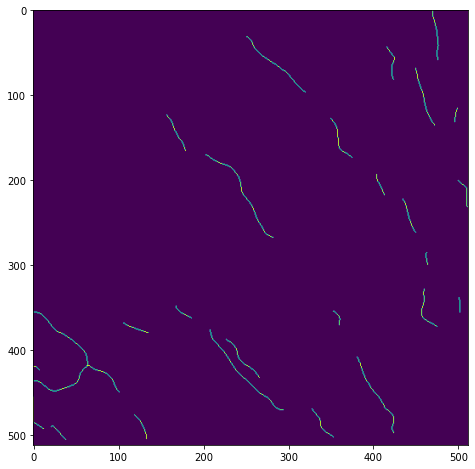

In [32]:
plt.figure(figsize=(8, 8))
plt.imshow(draw_raw)

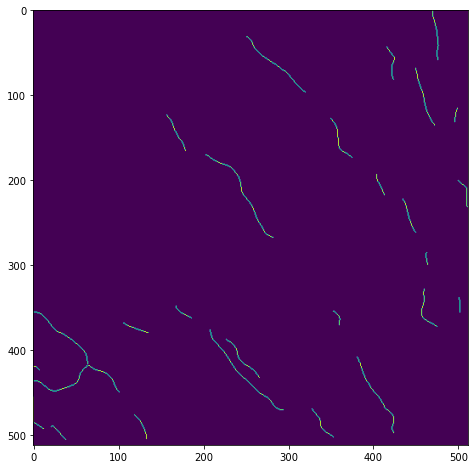

In [36]:
joints_coords, filtered_image = joint_filter(draw_raw)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(draw_raw, cmap=plt.cm.gray)
ax.plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

In [18]:
data_path = 'round_1_mike'
label_csvs = glob(os.path.join(data_path, 'labels', '*.csv'))
for label_csv_name in tqdm(label_csvs):
    label_csv = pd.read_csv(label_csv_name, index_col=0)
    line_dict = sort_lines(label_csv)
    end_points = [[item.points[0], item.points[-1]] for key, item in line_dict.items()]
    end_points = reduce(lambda x1, x2 : x1+x2, end_points) # flatten
    close_points = lambda pt_1, pt_2, dist_thresh : math.sqrt((pt_1.x-pt_2.x)**2 + (pt_1.y-pt_2.y)**2) < dist_thresh
    points_dist = lambda pt_1, pt_2 : math.sqrt((pt_1.x-pt_2.x)**2 + (pt_1.y-pt_2.y)**2)
    # points_grad = lambda pt_1, pt_2, beta=1e-3 : (pt_1.x-pt_2.x)/(pt_1.y-pt_2.y+beta)
    points_angle = lambda pt_1, pt_2, beta=1e-3 : math.atan2((pt_1.y-pt_2.y), (pt_1.x-pt_2.x)) # point to first point

    joints = []
    while len(end_points):
        current_point = end_points.pop() # pop one element
        
        for point in end_points:
            pop_point = close_points(current_point, point, joint_thresh) # compare to the rest
            if pop_point:
                end_points.remove(point)
            if pop_point:
                joints.append(current_point)
    joints = list(set(joints))

    grad_list = []
    joint_IDs = []
    for idx, joint in enumerate(joints):
        for k, v in line_dict.items():
            # print(v.points)
            if close_points(v.points[0], joint, joint_thresh):
                angle_start = line_gradient(v.points, -1) # backwards
                grad_list.append(Joint(k, idx, -1, angle_start))
                joint_IDs.append(idx)
            if close_points(v.points[-1], joint, joint_thresh):
                angle_end = line_gradient(v.points, 1) # forwards
                grad_list.append(Joint(k, idx, 1, angle_end))
                joint_IDs.append(idx)
    joint_IDs = list(set(joint_IDs))

    joint_dict = {}
    for joint_ID in joint_IDs:
        joint_dict[str(joint_ID)] = []
    for joint_ID in joint_IDs:
        for grad in grad_list:
            if grad.joint_ID==joint_ID:
                joint_dict[str(joint_ID)].append(grad)
    link_dict = {}
    for k, v in joint_dict.items():
        grads = [i.gradient for i in v]
        diff = [abs(abs(i[0]-i[1])-180) for i in list(product(grads, grads))]
        result = [i for i, x in enumerate(diff) if x<angle_thresh]
        result = [frozenset((i//len(grads), i%len(grads))) for i in result]
        result = set(result)
        result = [set(i) for i in result]
        result_copy = result.copy()
        if len(result) > 1:
            pair_score = [abs(abs(grads[tuple(line_pair)[0]]-grads[tuple(line_pair)[1]])-180) for line_pair in result]
            sorted_result = [x for _, x in sorted(zip(pair_score, result))]
            running_set = set()
            pruned_result = []
            for line_pair in sorted_result:
                if len(line_pair.intersection(running_set))==0:
                    pruned_result.append(line_pair)
                    running_set = running_set.union(line_pair)

            result = [tuple(i) for i in pruned_result]
        else:
            result = [tuple(i) for i in result]
        link_dict[k] = result

    for (k_1,v_1), (k_2,v_2) in zip(link_dict.items(), joint_dict.items()):
        for i in v_1:
            line_a = v_2[i[0]]
            line_b = v_2[i[1]]
            if line_a.dir==1: # a tail
                line_dict[line_a.line_ID] = Line(line_dict[line_a.line_ID].points, head=line_dict[line_a.line_ID].head, tail=line_b.line_ID) #
            if line_a.dir==-1: # a head
                line_dict[line_a.line_ID] = Line(line_dict[line_a.line_ID].points, head=line_b.line_ID, tail=line_dict[line_a.line_ID].tail)
            if line_b.dir==1: # b tail
                line_dict[line_b.line_ID] = Line(line_dict[line_b.line_ID].points, head=line_dict[line_b.line_ID].head, tail=line_a.line_ID)
            if line_b.dir==-1: # b head
                line_dict[line_b.line_ID] = Line(line_dict[line_b.line_ID].points, head=line_a.line_ID, tail=line_dict[line_b.line_ID].tail)

    line_dict_copy = line_dict.copy()
    heads = max([int(v.head) for k, v in line_dict_copy.items()])
    tails = max([int(v.tail) for k, v in line_dict_copy.items()])
    max_attemp = 0
    while not(heads==-1 and tails==-1):
        max_attemp += 1
        line_dict_copy = connect_lines(line_dict_copy)
        heads = max([int(v.head) for k, v in line_dict_copy.items()])
        tails = max([int(v.tail) for k, v in line_dict_copy.items()])
        if max_attemp > 100:
            break

    image = np.zeros((image_size, image_size), np.uint8)
    for k, v in line_dict_copy.items():
        points = v.points
        image = draw_line(points, image)
    image = morphology.dilation(image)
    image = img_as_ubyte(transform.resize(image, (image_size, image_size), order=0, anti_aliasing=True))
    _, image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    image = morphology.skeletonize(img_as_bool(image))
    save_name = os.path.join(data_path, 'masks'+os.sep) + label_csv_name.split(os.sep)[-1]
    cv2.imwrite(save_name.replace('csv', 'tif'), img_as_ubyte(image))
        

  0%|          | 0/25 [00:00<?, ?it/s]

In [15]:
cv2.imwrite(save_name.replace('csv', 'tif'), img_as_ubyte(image))

False

In [12]:
data_path

'round_1_mike'

In [ ]:
image = np.zeros((image_size, image_size), np.uint8)
for k, v in line_dict_copy.items():
    points = v.points
    image = draw_line(points, image)
image = morphology.dilation(image)
image = img_as_ubyte(transform.resize(image, (image_size, image_size), order=0, anti_aliasing=True))
_, image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
image = morphology.skeletonize(img_as_bool(image))
cv2.imwrite('test.tif', img_as_ubyte(image))

True